# 폐렴 진단 프로젝트

## - 목차   
1. 변수 설정 및 초기화   
2. 데이터 로드 및 데이터 준비   
  2.1 augmentation을 도입한 데이터 세트 생성   
  2.2 ImageDataGenerator를 이용한 데이터 세트 생성    
3. 데이터 시각화   
4. 모델링   
  4.1 CNN 모델링   
    4.1.1 시도1,시도2에서 사용할 CNN 모델 설계   
    4.1.2 시도 3에서 사용할 CNN 모델 설계   
  4.2 데이터 불균형 처리    
  4.3 모델 훈련   
5. 모델 평가 - 학습 결과 시각화 및 테스트 데이터로 모델 평가   
  5.1 성능 개선 시도 1   
  5.2 성능 개선 시도 2   
  5.3 성능 개선 시도 3

- 프로젝트 정리   

## 1. 변수 설정 및 초기화

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [4]:
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.1


In [5]:
#데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

#X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

#데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

#변경 가능한 파라미터
BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. 데이터 로드 및 데이터 준비

In [6]:
#데이터 로드
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [7]:
#val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옴.
#train 데이터와 validation 데이터를 모두 filenames에 담음.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

#train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할.
train_size = math.floor(len(filenames)*0.8)
random.seed(1234)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [8]:
#정상 이미지와 폐렴 이미지의 구분은 파일 경로로 할 수 있음.
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0711-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1343_virus_2317.jpeg


In [9]:
#파일 경로에 NORMAL과 PNEUMONIA이 있는지로 
#정상 이미지와 폐렴 이미지 파일을 구별 할 수 있음.

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


In [10]:
#tf.data 인스턴스 만들기
#tf.data는 tensorflow에서 학습시킬 때 배치처리 작업을 보다 효율적으로 할 수 있도록 해줌.

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
#train, validation 데이터셋 개수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [12]:
#파일 경로의 'NORMAL', 'PNEUMONIA'로 라벨 데이터를 만들 것.
#파일 경로 내에 'PNEUMONIA'가 있으면 양성(True), 'NORMAL'이 있으면 음성(False)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    
    return parts[-2] == "PNEUMONIA" 

In [13]:
#제각각인 이미지 사이즈를 알맞은 사이즈와 형식으로 바꿈.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) #float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) #이미지 사이즈를 IMAGE_SIZE(180, 180)로 수정
    
    return img

#이미지 파일의 경로를 인풋으로 받아 이미지와 라벨을 반환하는 함수.
def process_path(file_path):
    label = get_label(file_path) #라벨 검출
    img = tf.io.read_file(file_path) #이미지 읽기
    img = decode_img(img) #이미지를 알맞은 형식으로 수정
    
    return img, label

In [14]:
#train, validation 데이터셋을 만듦.
#위에서 변수 설정 시 초기화 한 AUTOTUNE을 사용해서 빠르게 데이터를 처리.

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
#이미지 리사이징, 라벨 확인.
#train_ds.take(1)은 하나의 데이터만 가지고 온다는 의미
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
#test 데이터셋 만들기.
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 2.1 성능 개선 시도 1(5.1.1), 성능 개선 시도2(5.1.2)를 위한 데이터세트 생성

In [14]:
###### 시도 1, 시도 2 에서 사용한 데이터세트 만들기 ######

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  #랜덤하게 좌우를 반전.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    #augment 적용 부분이 배치처리 함수에 추가.
    ds = ds.map(
            augment,       #augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

###  2.2 성능 개선 시도 3(5,1,3)을 위한 데이터세트 생성

In [17]:
###### 시도 3에서 사용한 ImageDataGenerator를 통한 데이터 세트 만들기######

train_data_dir = str(ROOT_PATH + '/chest_xray/data/train')
validation_data_dir = str(ROOT_PATH + '/chest_xray/data/val')
test_data_dir = str(ROOT_PATH + '/chest_xray/data/test')


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_data_dir,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'binary')

validation_set = test_datagen.flow_from_directory(validation_data_dir,
                                            target_size = IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')

test_set = test_datagen.flow_from_directory(test_data_dir,
                                            target_size = IMAGE_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. 데이터 시각화

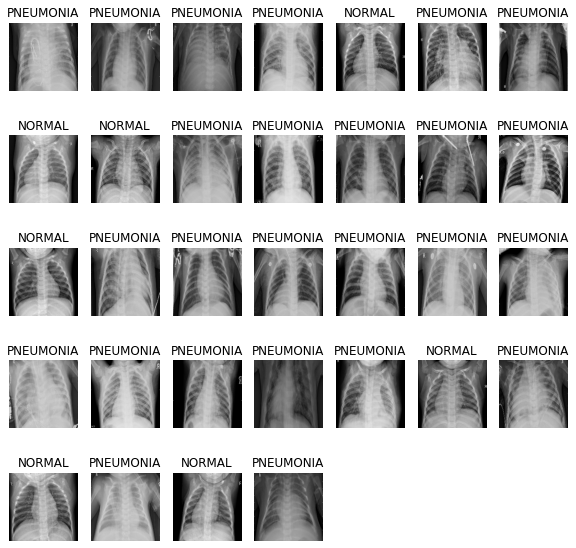

In [16]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

#train에 있는 batch 중 첫 번째 배치를 추출해서 image와 label 데이터 셋으로 나눔.
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. 모델링

### 4.1.1 CNN 모델링
- 시도 1, 시도 2 에서 사용한 모델

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512),
        dense_block(128),
        dense_block(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 4.1.2 ImageDataGenerator를 위한 CNN 모델링
- 시도 3에서 사용한 모델

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### 4.2 데이터 불균형 처리

In [19]:
#이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨.

#'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 

# 'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


### 4.3 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    #model = build_model()   ### 시도 3에서는 build_model()을 사용하지 않기에 주석 처리함.

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]  #성과 측정 위함
    
    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',  #라벨이 두개 뿐이니까 binary_crossentropy 사용
        metrics=METRICS,
        
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        training_set,
        steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs = EPOCHS,
        validation_data = validation_set,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
        class_weight = class_weight,
    )

Epoch 1/25
130/130 [==============================] - 85s 654ms/step - loss: 0.5934 - accuracy: 0.7099 - precision: 0.8671 - recall: 0.7230 - val_loss: 0.3014 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 2/25
130/130 [==============================] - 82s 628ms/step - loss: 0.3612 - accuracy: 0.8606 - precision: 0.9452 - recall: 0.8627 - val_loss: 0.2342 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/25
130/130 [==============================] - 81s 626ms/step - loss: 0.3245 - accuracy: 0.8666 - precision: 0.9494 - recall: 0.8668 - val_loss: 0.3724 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 82s 632ms/step - loss: 0.3435 - accuracy: 0.8829 - precision: 0.9578 - recall: 0.8813 - val_loss: 0.8355 - val_accuracy: 0.6250 - val_precision: 0.5714 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 81s 626ms/step - loss: 0.2624 - accura

130/130 [==============================] - 81s 622ms/step - loss: 0.2214 - accuracy: 0.9296 - precision: 0.9739 - recall: 0.9302 - val_loss: 0.8309 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 15/25
130/130 [==============================] - 81s 620ms/step - loss: 0.2874 - accuracy: 0.9240 - precision: 0.9710 - recall: 0.9260 - val_loss: 0.1562 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 16/25
130/130 [==============================] - 81s 620ms/step - loss: 0.1965 - accuracy: 0.9312 - precision: 0.9789 - recall: 0.9279 - val_loss: 0.4792 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 17/25
130/130 [==============================] - 80s 619ms/step - loss: 0.2057 - accuracy: 0.9353 - precision: 0.9751 - recall: 0.9371 - val_loss: 0.7127 - val_accuracy: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000
Epoch 18/25
130/130 [==============================] - 81s 625ms/step - loss: 0.2022 - accuracy: 0.9

## 5. 모델 평가 - 학습 결과 시각화 및 테스트 데이터로 모델 평가

### - 5.1 성능 개선 시도 1 : 
- Batch size 16 -> 32
- 데이터 전처리 및 배치 구성 후 좌우 반전 augmentation 도입
- BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하지 않음(Dropout 제외시킴)
- optimizer = 'adam' 사용 

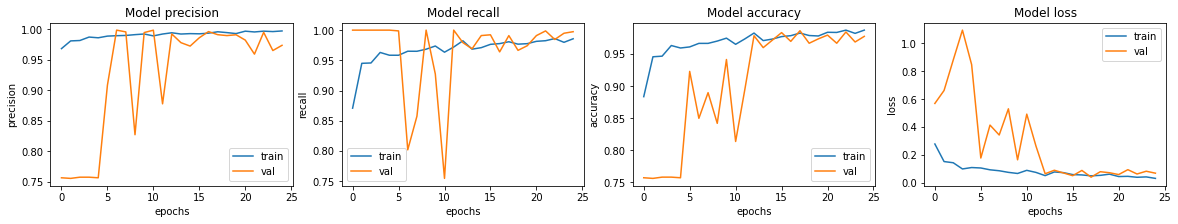

In [26]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 9s 452ms/step - loss: 1.4936 - accuracy: 0.7212 - precision: 0.6922 - recall: 0.9974
Loss: 1.4936217069625854,
Accuracy: 0.7211538553237915,
Precision: 0.6921707987785339,
Recall: 0.9974358677864075


### - 5.2 성능 개선 시도 2 : 
- 시도1과 전부 동일하지만 optimizer를 adma 대신 'rmsprop' 사용.

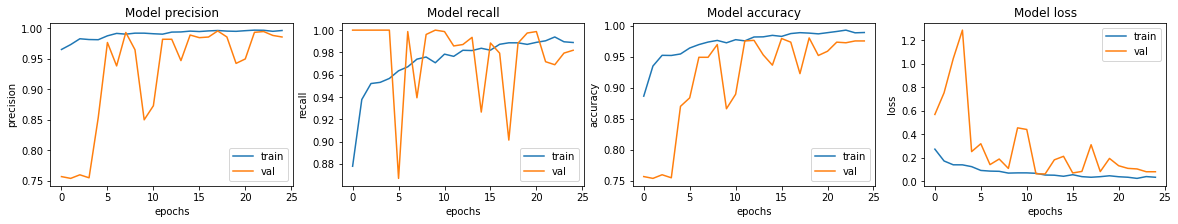

In [30]:
#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [31]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 3s 139ms/step - loss: 1.0378 - accuracy: 0.8125 - precision: 0.7769 - recall: 0.9821
Loss: 1.0377525091171265,
Accuracy: 0.8125,
Precision: 0.7768762707710266,
Recall: 0.9820512533187866


### - 5.3 성능 개선 시도 3 :
- keras에서는 이미지 데이터 학습을 쉽게 하기 위해 ImageDataGenerator 클래스를 제공한다.
- ImageDataGenerator 클래스를 통해 객체를 생성할 때 파라미터를 전달해주는 것을 통해 데이터의 전처리를 쉽게할 수 있다.
- ImageDataGenerator와는 별개로 CNN 모델을 만들어 주어야 하기 때문에 4.1.2와 같이 모델을 설계했다.
- ImageDataGenerator을 사용하여 데이터세트를 만들어 모델 학습을 시켰을 때 모델이 학습하면서 해당 경고를 봤는데,
  - "WARNING:tensorflow:Your input ran out of data ; interrupting training. Make sure that your dataset or generator can generate at least 'steps_per_epoch*epochs' batched."
- 이 경고가 나오고 나서 validation에 대한 정보가 epoch1 이후로는 출력이 되지 않아 tensorflow와 keras 버전을 다운그레이드 해주었다. (keras : 2.3.1, tensorflow : 2.2.0)
- 다운그레이드 해주기 전에는 아래 결과물과 같이 validation 그래프가 출력되지 않았다.

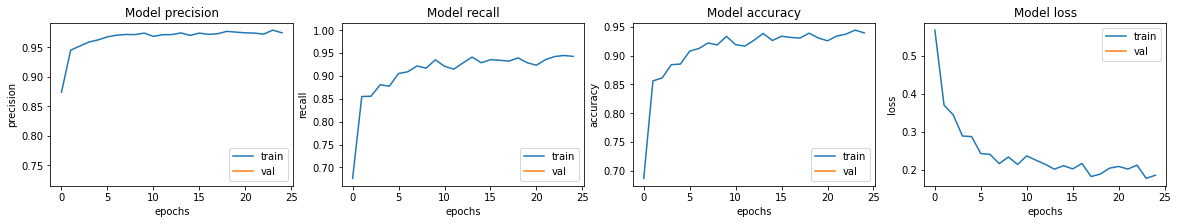

In [30]:
##### tensorflow와 keras 버전으로 인해 'val_+met'의 값이 나오지 않아 그래프에 표시 되지 않음 #####

#그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

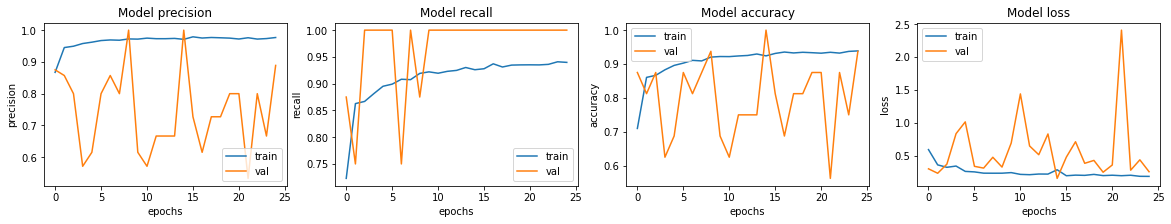

In [23]:
##### tensorflow와 keras 버전을 다운그레이드 해 준 후 결과 #####
## keras : 2.3.1, tensorflow : 2.2.0

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 4s 215ms/step - loss: 0.2572 - accuracy: 0.9022 - precision: 0.9273 - recall: 0.9154
Loss: 0.2571658492088318,
Accuracy: 0.9022436141967773,
Precision: 0.9272727370262146,
Recall: 0.9153845906257629


---

# 프로젝트 정리

### 1. 기본 모델 - 노드 (baseline) 코드   
![그림](https://github.com/YOOHYOJEONG/AIFFEL_LMS_project/blob/master/ex11/result/baseline_result.jpg?raw=true)   
- Accuracy: 0.6971153616905212   

### 2. 성능 개선 시도 1 (5.1) :
- 기본 모델에서 Batch size를 16 -> 32로 바꾸었다. 
- Augmentation를 도입했다.
- 기본 모델에서는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용했지만 일반적으로 이런 방법은 잘 사용되지 않기 때문에 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 것으로 수정했다.(Dropout 제외시킴)
- 또 optimizer로는 기본 모델과 같이 'adam'을 사용했다.   
- 그 결과 Accuracy는 0.7211538553237915으로 80%도 미치지 못하는 결과가 나왔다.   

### 3. 성능 개선 시도 2 (5.2) :
- 시도 1과 같은 조건에서 optimizer만 'rmsprop'로 변경하였다.
- optimizer만 바꾸었는데도  Accuracy는 0.8125로 80%가 조금 넘는 결과가 나왔다.    

### 4. 성능 개선 시도 3 (5.3) :
- 이미지 데이터 학습을 쉽게 하기 위해 ImageDataGenerator 클래스를 사용해서 데이터 세트를 생성했다.
- CNN 모델은 [참고 링크](https://3months.tistory.com/199)를 참고해서 설계했다으며 optimizer는 5.2와 같이 'rmsprop' 그대로 사용했다.
- Accuracy가 0.9022436141967773로 가장 좋은 결과가 나왔다.